In [13]:
#Creating Image Data Generator

In [14]:
import numpy as np
import cv2
import glob
import itertools
def generator(image_path, mask_path, batch_size, input_height, input_width, labels):
    
    assert image_path[-1] == '/'
    assert mask_path[-1] == '/'
    
    images = glob.glob( image_path + "*.png"  ) 
    images.sort()
    segmentations  = glob.glob( mask_path + "*.png"  )
    segmentations.sort()
    
    #no of images in both folders is same
    assert len( images ) == len(segmentations)
    
    #Files are in correspondance
    for im , seg in zip(images,segmentations):
        assert(  im.split('/')[-1].split(".")[0] ==  seg.split('/')[-1].split(".")[0] )
        
    zipped = itertools.cycle( zip(images,segmentations) )
    
    while True:
        X = []
        Y = []
        for _ in range( batch_size) :
            im , seg = next(zipped)
            
            img = cv2.imread(im)[:,:,::-1]
            img = img.astype(np.float32)
            img = img/255.0
            img = cv2.resize(img, ( input_width , input_height ),interpolation=cv2.INTER_NEAREST )
            
            
            X.append(img)
            
            img1 = cv2.imread(seg)
            img1 = cv2.resize(img1, ( input_width , input_height ),interpolation=cv2.INTER_NEAREST)[:,:,2]
            
            seg_labels = np.zeros((  input_height , input_width  , len(labels)))
            
            
            
            for c,l in enumerate(labels):
                seg_labels[: , : , c ] = ((img1 == l))*1
            
            seg_labels = seg_labels.astype(np.float32)
               
            Y.append(seg_labels)

        yield np.array(X) , np.array(Y)
    

In [15]:
a = generator('/home/vaibhavpec2013/Raw_Data/' , '/home/vaibhavpec2013/Mask_data/', 50, 256,256,labels)

In [16]:
b,c =next(a)

In [17]:
c[0]

array([[[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0.

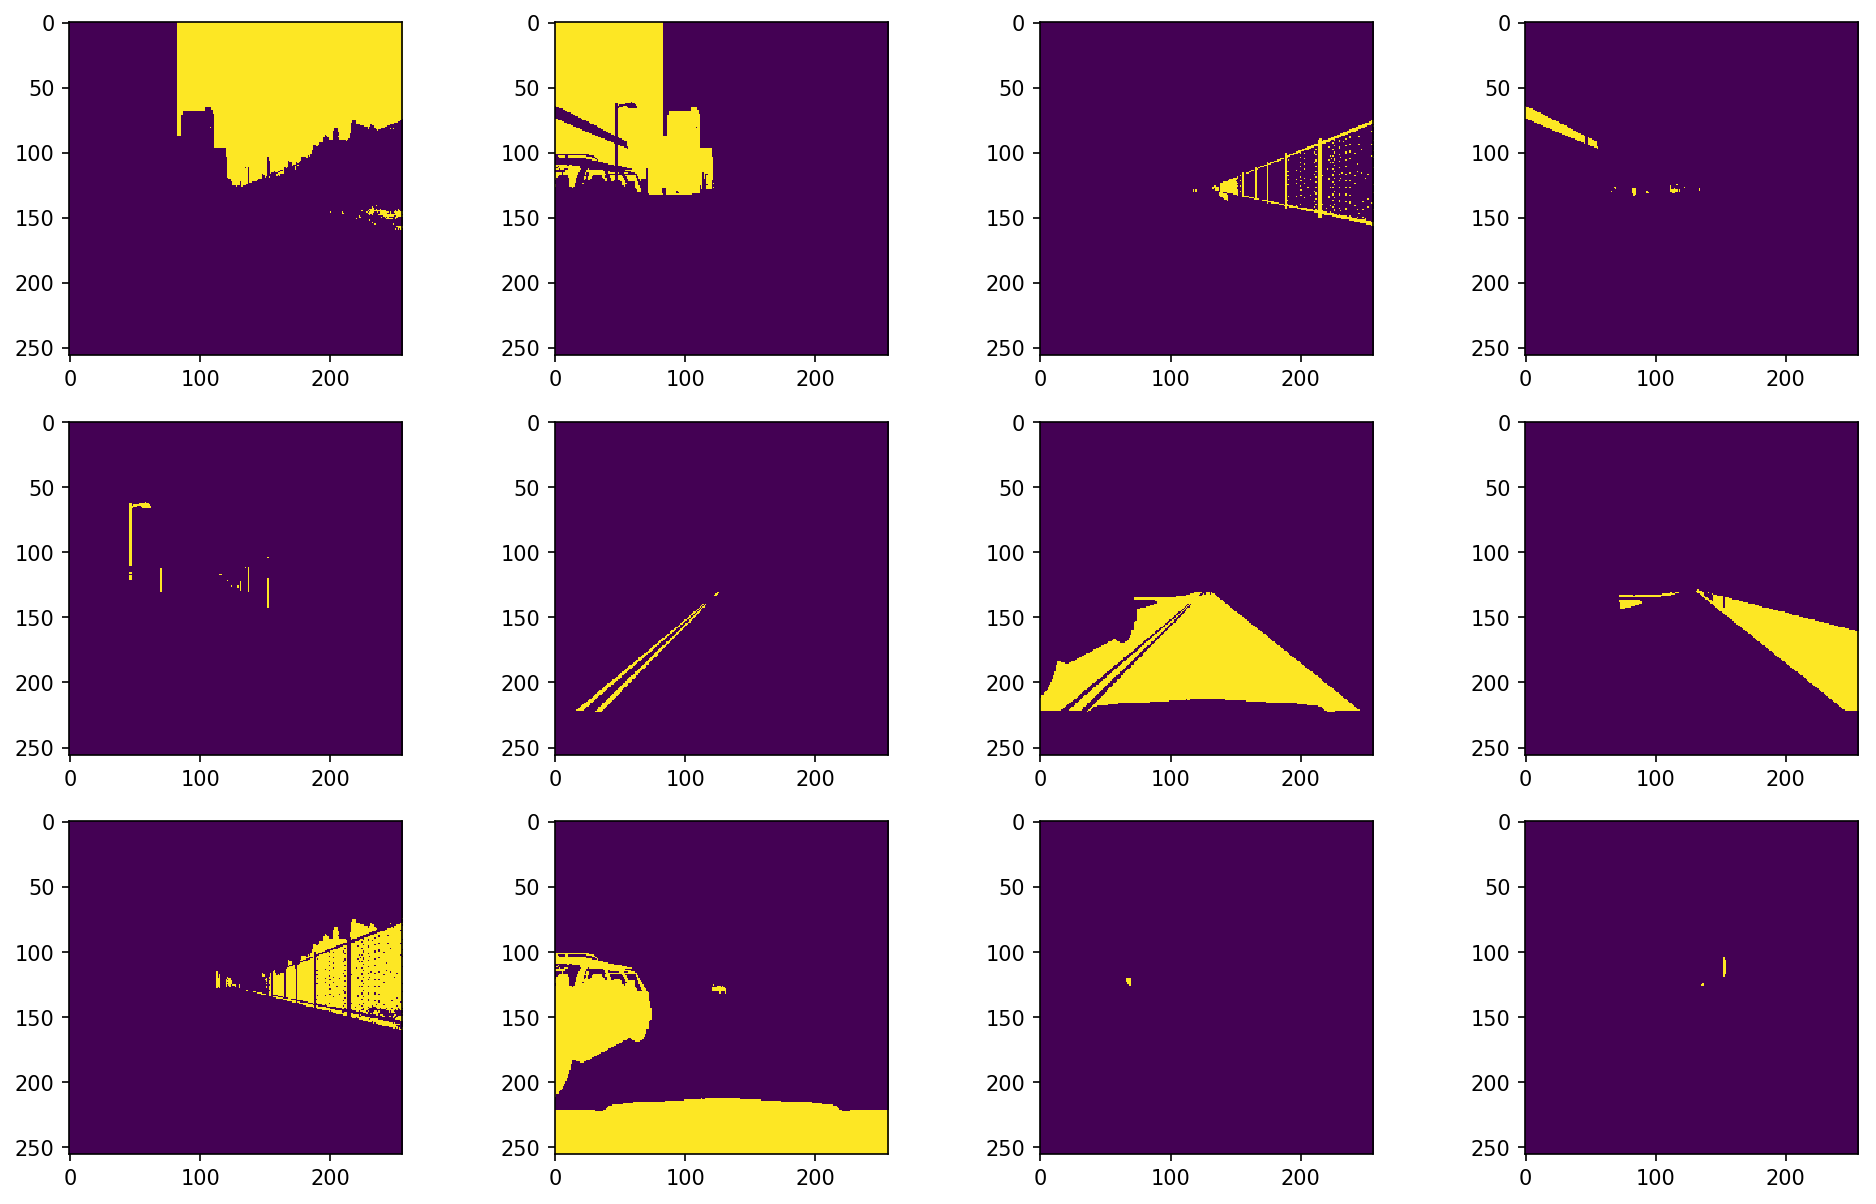

In [18]:
plt.figure( figsize=(16, 10), dpi=150)
for i in range(12):
    plt.subplot(3,4,i+1) 
    plt.imshow(c[0][:,:,i])

In [19]:
#Keras Model

In [20]:
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Deconvolution2D, Cropping2D
from keras.layers import Input, Add, Dropout, Permute, add
from scipy.io import loadmat

from keras.preprocessing.image import ImageDataGenerator, load_img

In [21]:
# Function to create to a series of CONV layers followed by Max pooling layer
def Convblock(channel_dimension, block_no, no_of_convs) :
    Layers = []
    for i in range(no_of_convs) :
        
        Conv_name = "conv"+str(block_no)+"_"+str(i+1)
        
        # A constant kernel size of 3*3 is used for all convolutions
        Layers.append(Convolution2D(channel_dimension,kernel_size = (3,3),padding = "same",activation = "relu",name = Conv_name))
    
    Max_pooling_name = "pool"+str(block_no)
    
    #Addding max pooling layer
    Layers.append(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),name = Max_pooling_name))
    
    return Layers

In [22]:
def FCN_8_helper(image_size):
    model = Sequential()
    model.add(Permute((1,2,3),input_shape = (image_size,image_size,3)))
    
    for l in Convblock(64,1,2) :
        model.add(l)
    
    for l in Convblock(128,2,2):
        model.add(l)
    
    for l in Convblock(256,3,3):
        model.add(l)
    
    for l in Convblock(512,4,3):
        model.add(l)
    
    for l in Convblock(512,5,3):
        model.add(l)
        
    model.add(Convolution2D(4096,kernel_size=(7,7),padding = "same",activation = "relu",name = "fc6"))
      
    #Replacing fully connnected layers of VGG Net using convolutions
    model.add(Convolution2D(4096,kernel_size=(1,1),padding = "same",activation = "relu",name = "fc7"))
    
    # Gives the classifications scores for each of the 21 classes including background
    model.add(Convolution2D(12,kernel_size=(1,1),padding="same",activation="relu",name = "score_fr"))
    
    Conv_size = model.layers[-1].output_shape[2] #16 if image size if 512
    #print(Conv_size)
    
    model.add(Deconvolution2D(12,kernel_size=(4,4),strides = (2,2),padding = "valid",activation=None,name = "score2"))
    
    # O = ((I-K+2*P)/Stride)+1 
    # O = Output dimesnion after convolution
    # I = Input dimnesion
    # K = kernel Size
    # P = Padding
    
    # I = (O-1)*Stride + K 
    Deconv_size = model.layers[-1].output_shape[2] #34 if image size is 512*512
    
    #print(Deconv_size)
    # 2 if image size is 512*512
    Extra = (Deconv_size - 2*Conv_size)
    
    #print(Extra)
    
    #Cropping to get correct size
    model.add(Cropping2D(cropping=((0,Extra),(0,Extra))))
    
    return model
    
    

In [23]:
def FCN_8(image_size):
    fcn_8 = FCN_8_helper(image_size)
    print(len(fcn_8.layers))
    #Calculating conv size after the sequential block
    #32 if image size is 512*512
    Conv_size = fcn_8.layers[-1].output_shape[2] 
    print(Conv_size)
    
    #Conv to be applied on Pool4
    skip_con1 = Convolution2D(12,kernel_size=(1,1),padding = "same",activation=None, name = "score_pool4")
    
    #Addig skip connection which takes adds the output of Max pooling layer 4 to current layer
    Summed = add(inputs = [skip_con1(fcn_8.layers[14].output),fcn_8.layers[-1].output])
    
    #Upsampling output of first skip connection
    x = Deconvolution2D(12,kernel_size=(4,4),strides = (2,2),padding = "valid",activation=None,name = "score4")(Summed)
    x = Cropping2D(cropping=((0,2),(0,2)))(x)
    
    
    #Conv to be applied to pool3
    skip_con2 = Convolution2D(12,kernel_size=(1,1),padding = "same",activation=None, name = "score_pool3")
    
    #Adding skip connection which takes output og Max pooling layer 3 to current layer
    Summed = add(inputs = [skip_con2(fcn_8.layers[10].output),x])
    
    #Final Up convolution which restores the original image size
    Up = Deconvolution2D(12,kernel_size=(16,16),strides = (8,8),
                         padding = "valid",activation = None,name = "upsample")(Summed)
    
    #Cropping the extra part obtained due to transpose convolution
    final = Cropping2D(cropping = ((0,8),(0,8)))(Up)
    
    
    return Model(fcn_8.input, final)

In [24]:
model = FCN_8(256)

24
16


In [25]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
permute_1_input (InputLayer)    (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 256, 256, 3)  0           permute_1_input[0][0]            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 256, 256, 64) 1792        permute_1[0][0]                  
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 256, 256, 64) 36928       conv1_1[0][0]                    
__________________________________________________________________________________________________
pool1 (Max

In [26]:
from keras.optimizers import Adam, RMSprop
from keras.metrics import categorical_crossentropy
model.compile(optimizer=Adam(lr=.00001), loss= 'categorical_crossentropy', metrics = ['accuracy'])

In [79]:
history = model.fit_generator( a , 100  , epochs=5 )
model.save( "model.h5")

Epoch 1/5
100/100 [==============================] - 162s 2s/step - loss: 1.1920e-07 - acc: 0.3128
Epoch 2/5
100/100 [==============================] - 160s 2s/step - loss: 1.1920e-07 - acc: 0.3128
Epoch 3/5
100/100 [==============================] - 160s 2s/step - loss: 1.1920e-07 - acc: 0.3128
Epoch 4/5
100/100 [==============================] - 161s 2s/step - loss: 1.1920e-07 - acc: 0.3128
Epoch 5/5
100/100 [==============================] - 160s 2s/step - loss: 1.1920e-07 - acc: 0.3128


In [80]:
img=cv2.imread('/home/vaibhavpec2013/Raw_Data/02_00_000.png')[:,:,::-1]
img = img.astype(np.float32)
img = img/255.0
img=cv2.resize(img,dsize=(256,256),interpolation=cv2.INTER_NEAREST)


In [81]:
img.shape

(256, 256, 3)

In [82]:
imarr = np.expand_dims(img, axis=0)

In [83]:
imarr.shape

(1, 256, 256, 3)

In [84]:
p = model.predict(imarr)

In [85]:
p[0]

array([[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       ..., 
       [[ nan,  nan, 

In [76]:
o = np.zeros((256,256))

for i in range(12):
    o[p[0][:,:,i]==1]=labels[i]

In [77]:
np.unique(o)

array([ 0.])